### Libraries

In [2]:

from typing import List
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from tqdm import tqdm


In [3]:
from typing import List
from textwrap import wrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(y_true: np.ndarray, y_hat: np.ndarray, figsize = (16, 9)):
    """
    Convenience function to display a confusion matrix in a graph.
    """
    labels = sorted(list(set(y_true)))
    df_lambda = pd.DataFrame(
        confusion_matrix(y_true, y_hat),
        index = labels,
        columns = labels
    )
    acc = accuracy_score(y_true, y_hat)
    f1s = f1_score(y_true, y_hat, average = 'weighted')

    fig, ax = plt.subplots(figsize = figsize)
    sns.heatmap(
        df_lambda, annot = True, square = True, cbar = False,
        fmt = 'd', linewidths = .5, cmap = 'YlGnBu',
        ax = ax
    )
    ax.set(
        title = f'Accuracy: {acc:.2f}, F1 (weighted): {f1s:.2f}',
        xlabel = 'Predicted',
        ylabel = 'Actual'
    )
    fig.suptitle('Confusion Matrix')
    plt.tight_layout()


In [4]:

pio.templates.default = 'plotly_white'
spacy.prefer_gpu()
nlp = spacy.load('en_core_web_sm', disable = ['ner'])


## I. Data Preparation

_In this section, we will explore the data and select texts for training._

In [5]:
df_osdg = pd.read_csv('https://zenodo.org/record/5550238/files/osdg-community-dataset-v21-09-30.csv?download=1')
print('Shape:', df_osdg.shape)
display(df_osdg.head())

Shape: (32121, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
1,10.18356/eca72908-en,00028349a7f9b2485ff344ae44ccfd6b,Labour legislation regulates maximum working h...,11,2,1,0.333333
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
3,10.1787/5k9b7bn5qzvd-en,0006a887475ccfa5a7f5f51d4ac83d02,The extent to which they are akin to corruptio...,3,1,2,0.333333
4,10.1787/9789264258211-6-en,0006d6e7593776abbdf4a6f985ea6d95,A region reporting a higher rate will not earn...,3,2,2,0.000000


In [6]:
df_lambda = df_osdg['agreement'].value_counts(normalize = True).sort_index().cumsum().to_frame(name = 'p_sum')
df_lambda.reset_index(inplace = True)
df_lambda.rename({'index': 'agreement'}, axis = 1, inplace = True)
print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (36, 2)


,agreement,p_sum
0,0.000000,0.033716
1,0.062432,0.033747
2,0.067982,0.033779
3,0.090909,0.033872
4,0.111111,0.050185


In [7]:
print('Shape before:', df_osdg.shape)
df_osdg = df_osdg.query('agreement >= .6 and labels_positive > labels_negative').copy()
print('Shape after :', df_osdg.shape)
display(df_osdg.head())

Shape before: (32121, 7)
Shape after : (17233, 7)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000


In [8]:
df_lambda = df_osdg.groupby('sdg', as_index = False).agg(count = ('text_id', 'count'))
df_lambda['share'] = df_lambda['count'].divide(df_lambda['count'].sum()).multiply(100)
print('Shape:', df_lambda.shape)
display(df_lambda.head())

Shape: (15, 3)


,sdg,count,share
0,1,1146,6.650032
1,2,827,4.798932
2,3,1854,10.758429
3,4,2324,13.485754
4,5,2286,13.265247


In [9]:
def preprocess_spacy(alpha: List[str]) -> List[str]:
   
    docs = list()
    
    for doc in tqdm(nlp.pipe(alpha, batch_size = 128)):
        tokens = list()
        for token in doc:
            if token.pos_ in ['NOUN', 'VERB', 'ADJ']:
                tokens.append(token.lemma_)
        docs.append(' '.join(tokens))
        
    return docs

In [10]:
df_osdg['docs'] = preprocess_spacy(df_osdg['text'].values)
print('Shape:', df_osdg.shape)
display(df_osdg.head())

17233it [02:18, 124.00it/s]

Shape: (17233, 8)


,doi,text_id,text,sdg,labels_negative,labels_positive,agreement,docs
0,10.6027/9789289342698-7-en,00021941702cd84171ff33962197ca1f,"From a gender perspective, Paulgaard points ou...",5,1,7,0.750000,gender perspective point labour market fishing...
2,10.1787/9789264289062-4-en,0004eb64f96e1620cd852603d9cbe4d4,The average figure also masks large difference...,3,1,6,0.714286,average figure mask large difference region nu...
7,10.1787/9789264117563-8-en,000bfb17e9f3a00d4515ab59c5c487e7,The Israel Oceanographic and Limnological Rese...,6,0,3,1.000000,station monitor quantity quality water coastli...
8,10.18356/805b1ae4-en,001180f5dd9a821e651ed51e30d0cf8c,Previous chapters have discussed ways to make ...,2,0,3,1.000000,previous chapter discuss way make food system ...
11,10.1787/9789264310278-en,001f1aee4013cb098da17a979c38bc57,Prescription rates appear to be higher where l...,8,0,3,1.000000,prescription rate appear high labour force par...


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    df_osdg['docs'].values, 
    df_osdg['sdg'].values, 
    test_size = .3,
    random_state = 42
)

print('Shape train:', X_train.shape)
print('Shape test:', X_test.shape)

Shape train: (12063,)
Shape test: (5170,)


In [12]:
type(X_train)

numpy.ndarray

In [14]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier#62
pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(
        ngram_range = (1, 2),
        max_df = 0.75,
        min_df = 2,
        max_features = 100_000
    )),
    ('selector', SelectKBest(f_classif, k = 5_000)),
    ('clf', BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(max_df=0.75, max_features=100000, min_df=2,
                                 ngram_range=(1, 2))),
                ('selector', SelectKBest(k=5000)),
                ('clf',
                 BaggingClassifier(base_estimator=KNeighborsClassifier(),
                                   max_features=0.5, max_samples=0.5))])

In [15]:
y_train

array([ 5,  2,  2, ...,  7, 13,  1])

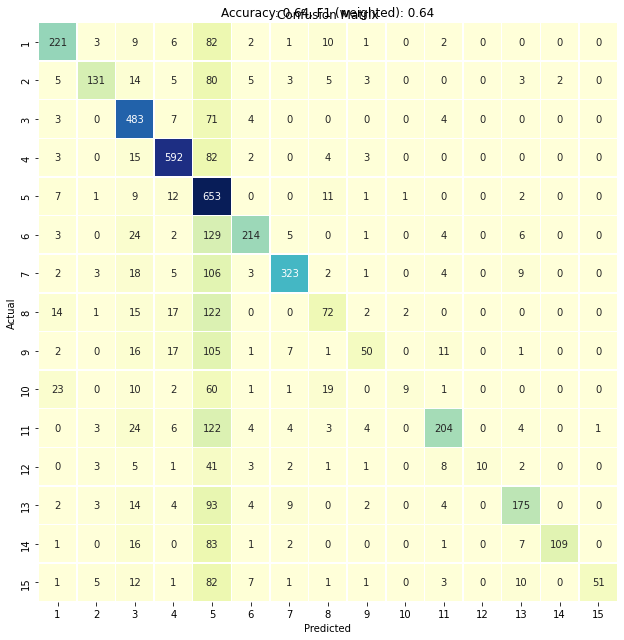

In [16]:
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

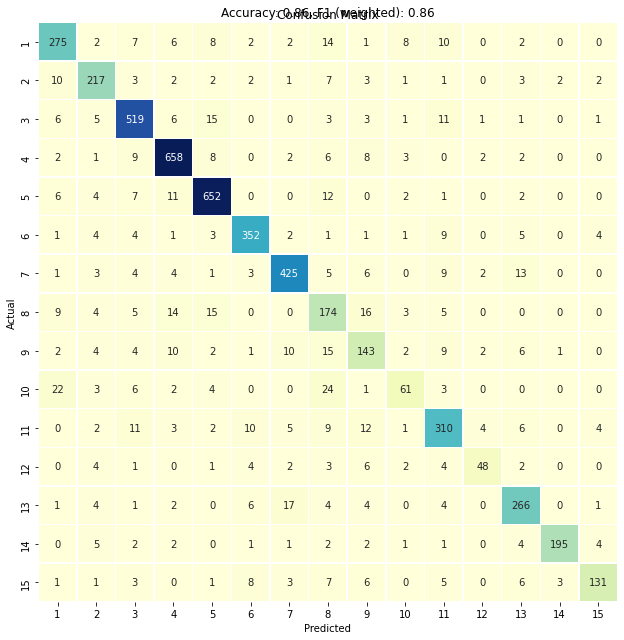

In [17]:
from sklearn.svm import SVC

svck = SVC(kernel='poly',degree=1)
pipe = Pipeline([
    ('vectoriser', TfidfVectorizer(ngram_range = (1, 2), max_df = 0.75, min_df = 2, max_features = 100_000)),
    ('selector', SelectKBest(f_classif, k = 1_000)),
    ('clf', svck)
])

pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)
plot_confusion_matrix(y_test, y_hat)

In [ ]:
import pickle
pickle_out = open("classifier.pkl","wb")
pickle.dump(pipe, pickle_out)
pickle_out.close()

In [ ]:
print(X_test[0])